## Generating a Job to execute on Pasqal hardware

In [74]:
import numpy as np

from qat.core import Schedule, Variable
from qat.core.variables import heaviside

from pulser import Pulse, Sequence
from pulser.waveforms import CustomWaveform
from pulser.devices import AnalogDevice
from pulser_myqlm import IsingAQPU
from pulser_myqlm.myqlmtools import are_equivalent_schedules

On Pulser we can solve problems of shape 
$$ H = \hbar \sum_i \frac{\Omega(t)}{2}(\cos(\phi) \sigma_i^x - \sin(\phi) \sigma_i^y) - \frac{\delta(t)}{2}\sigma_i^z + \frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$$
with $\sigma_i^x$, $\sigma_i^y$, $\sigma_i^z$ the Pauli operators $X$, $Y$, $Z$ applied on qubit $i$ and $n_i = \frac{1+\sigma_i^z}{2}$.

This Hamiltonian is named the <u>Ising Hamiltonian</u>. It is composed of a time-independent part, $\frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$, and the rest of the terms that make a time-dependent Hamiltonian. In Pulser, this Hamiltonian is generated via a `Sequence` object. It is initialized by a `Device` and a `Register` that define the coefficients $U_{ij}$. Then, `Pulse`s are added to this `Sequence` to generate the time-dependent terms of this Hamiltonian. You can find more information about this Ising Hamiltonian in the [Pulser documentation](https://pulser.readthedocs.io/en/stable/review.html).  

The [pulser-myqlm package](https://github.com/pasqal-io/Pulser-myQLM) and its `IsingAQPU` class enables you to either generate step-by-step such an Ising Hamiltonian in a MyQLM `Schedule` or `Job`, or to convert a Pulser Sequence into a MyQLM `Schedule` or `Job` directly. We will introduce the two methods in the next two sections. 

### Step-by-step creation of MyQLM Schedule and Job using IsingAQPU

#### Defining an IsingAQPU

On Pulser, any simulation starts by defining a `Device` and a `Register`. Any `IsingAQPU` should be defined by these two objects. It can also be defined by a `Sequence` directly, this is explained in the next section.

`IsingAQPU` describes an abstract QPU on which only pulses applied on a `Rydberg.Global` channel can be run. This generates the Ising Hamiltonian described above. 

Pulser provides examples of Pasqal devices in `pulser.devices`. Any of these devices can be used for simulation purposes, yet the device representing best the `IsingAQPU` and Pasqal QPUs is `AnalogDevice`. 

In real pulser devices, only some `Register` can be implemented. They must be built from a `RegisterLayout` in the `calibrated_register_layouts` of the `Device`. Let's have a look to one of the calibrated layouts of `AnalogDevice`:



{'TriangularLatticeLayout(61, 5.0µm)': RegisterLayout_f771cf8ed8632985d8a9932015027bd73e90391c049e8a8591e2c663febcaafe}


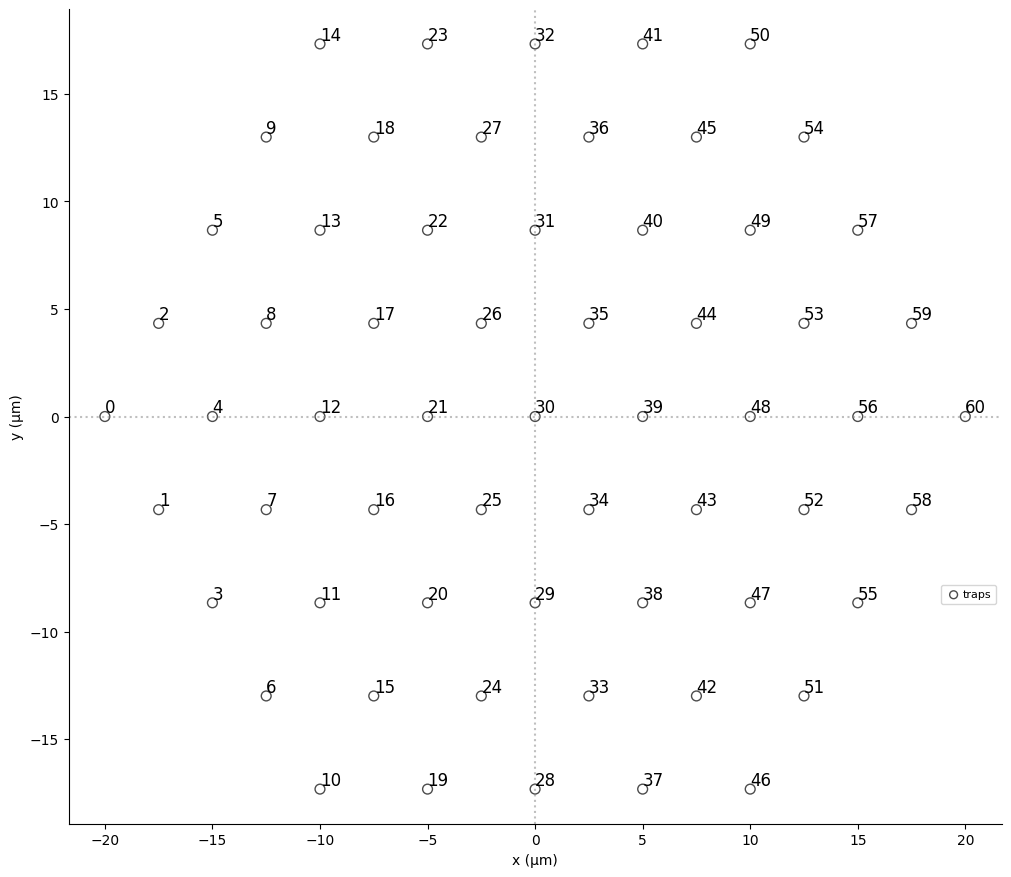

In [75]:
print(AnalogDevice.calibrated_register_layouts)
analog_layout = AnalogDevice.calibrated_register_layouts[
    "TriangularLatticeLayout(61, 5.0µm)"
]
analog_layout.draw()

The registers must be a subset of the calibrated layouts of `AnalogDevice`. They must be defined using the `define_register` method of the layouts. You can read more about registers and layouts [in the pulser documentation](https://pulser.readthedocs.io/en/stable/tutorials/reg_layouts.html).

Let's define a Register of triangular shape with sites 26, 35 and 30. The sites are spaced by 5µm.

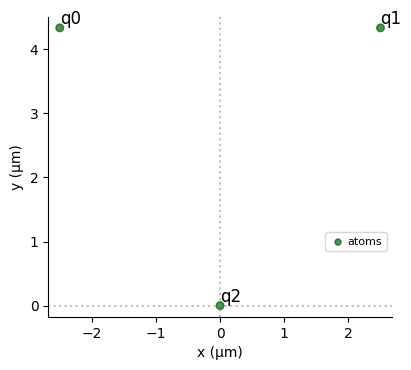

In [76]:
register = analog_layout.define_register(26, 35, 30)
register.draw()

Let's finally build an `IsingAQPU` with the `AnalogDevice` and the triangular register.

This `IsingAQPU` defines the interaction matrix between each atom, described by the matrix $U_{ij}$ in the Ising Hamiltonian. This interaction matrix can be accessed via the property `c6_interactions` of the `IsingAQPU`. Since the distances between each atom is the same, the interaction coefficients are expected to be the same as well.

In [77]:
aqpu = IsingAQPU(AnalogDevice, register)
# Check qpu properties
print(
    "Distances (in um):\n", aqpu.distances, "\n"
)  # symetric matrix, for each qubit two qubits are at 4um distance and one at 4 * sqrt(2) um
print("Interactions (in rad/us):\n", aqpu.c6_interactions)  # Interaction matrix U_{ij}

Distances (in um):
 [[0. 5. 5.]
 [5. 0. 5.]
 [5. 5. 0.]] 

Interactions (in rad/us):
 [[ 0.         55.40627328 55.40627328]
 [55.40627328  0.         55.40627328]
 [55.40627328 55.40627328  0.        ]]


#### Generating time-dependent Ising Hamiltonians

In the Ising Hamiltonian, the parameters of the time-dependent part of the Hamiltonian are $\Omega$, $\delta$ and $\phi$. They are the amplitude, detuning and phase of a `Pulse` in Pulser. The amplitude and the detuning can be time-dependent, whereas the phase is constant. Let's start by defining some time-dependent amplitude and detuning:

In [78]:
t_variable = Variable("t")  # in ns
u_variable = Variable("u")  # parameter
omega_t = 10 * t_variable  # in rad/us
delta_t = 1 - 10 * t_variable + u_variable  # in rad/us

We can then compute the Ising Hamiltonians associated to pulses defined by $\Omega$, $\delta$, $\phi$ using `IsingAQPU.hamiltonian`.

- Here is an Hamiltonian associated with a pulse of constant amplitude $\Omega=1rad/\mu s$, zero detuning and phase.
It is equivalent to apply a X gate on each qubit, and ZZ gates whose coefficients are defined from the Van der Waals interactions between the atoms.

In [79]:
t1 = 100 / 1000  # in µs
H1 = aqpu.hamiltonian(1, 0, 0)  # omega(t)=1, delta(t)=0, phi=0
print(H1)  # in rad/us

41.55470496 * I^3 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
27.70313664 * (Z|[0]) +
27.70313664 * (Z|[1]) +
27.70313664 * (Z|[2])


- If now the phase is equal to $\pi / 2$, we no longer add a X gate on each qubit but a Y gate.

In [80]:
t2 = 100 / 1000  # in µs
H2 = aqpu.hamiltonian(1, 0, np.pi / 2)  # omega(t)=1, delta(t)=0, phi=pi/2
print(H2)  # in rad/us

41.55470496 * I^3 +
-0.5 * (Y|[0]) +
-0.5 * (Y|[1]) +
-0.5 * (Y|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
27.70313664 * (Z|[0]) +
27.70313664 * (Z|[1]) +
27.70313664 * (Z|[2])


- It is also possible to define time-dependent pulses, varying in amplitude and detuning. See that the coefficients in front the ZZ operators are unchanged.

In [81]:
t0 = 100 / 1000  # in µs
H0 = aqpu.hamiltonian(omega_t, delta_t, 0)  # omega(t)=omega_t, delta(t)=delta_t, phi=0
print(H0)  # in rad/us

41.55470496 * I^3 +
((10 * t) / 2.0) * (X|[0]) +
((10 * t) / 2.0) * (X|[1]) +
((10 * t) / 2.0) * (X|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[0]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[1]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[2])


Note that the output of `IsingAQPU.hamiltonian` is an Hamiltonian in $rad/\mu s$. It has to be multiplied by $\hbar$ to be in energy units.

#### Making a Schedule and a Job of Ising Hamiltonians

The Hamiltonian is implemented as the drive of a `Schedule` object. You also have to define the duration of the evolution of this `Schedule` object. In Pulser, the duration of Pulses are defined as integers in nanoseconds. However, in Pulser-MyQLM, the durations are in µs as the Observables are in rad/µs. 

A `Schedule` can be implemented on the `IsingAQPU` if the coefficients in front of the ZZ operators match the Van der Waals interactions. Therefore, when using hamiltonians defined with `IsingAQPU`, the sum of the drive coefficients should be equal to 1 along the duration of the `Schedule`.

In [82]:
schedule0 = Schedule(drive=[(1, H0)], tmax=t0)  # tmax in µs
schedule1 = Schedule(drive=[(1, H1)], tmax=t1)
schedule2 = Schedule(drive=[(1, H2)], tmax=t2)

In [83]:
schedule = schedule0 | schedule1 | schedule2
print(schedule)

drive:
(heaviside(t,0,0.2) * heaviside(t,0,0.1)) * 41.55470496 * I^3 +
((10 * t) / 2.0) * (X|[0]) +
((10 * t) / 2.0) * (X|[1]) +
((10 * t) / 2.0) * (X|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[0]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[1]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[2])
(heaviside(t,0,0.2) * heaviside(t,0.1,0.2)) * 41.55470496 * I^3 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
27.70313664 * (Z|[0]) +
27.70313664 * (Z|[1]) +
27.70313664 * (Z|[2])
heaviside(t,0.2,0.30000000000000004) * 41.55470496 * I^3 +
-0.5 * (Y|[0]) +
-0.5 * (Y|[1]) +
-0.5 * (Y|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
27.70313664 * (Z|[0]) +
27.70313664 * (Z|[1]) +
27.70313664 * (Z|[2])
tmax = 0.30000000000000004


Here is an equivalent definition of the former `Schedule`, using `heaviside` explicitly instead of temporal compositions.

In [84]:
schedule_sum = Schedule(
    drive=[
        [heaviside(t_variable, 0, t0), H0],
        [heaviside(t_variable, t0, t1 + t0), H1],
        [heaviside(t_variable, t1 + t0, t1 + t0 + t2), H2],
    ],
    tmax=t1 + t0 + t2,
)
print(schedule_sum)

drive:
heaviside(t,0,0.1) * 41.55470496 * I^3 +
((10 * t) / 2.0) * (X|[0]) +
((10 * t) / 2.0) * (X|[1]) +
((10 * t) / 2.0) * (X|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[0]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[1]) +
(27.70313664 + (-(((1 - (10 * t)) + u)) / 2.0)) * (Z|[2])
heaviside(t,0.1,0.2) * 41.55470496 * I^3 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
27.70313664 * (Z|[0]) +
27.70313664 * (Z|[1]) +
27.70313664 * (Z|[2])
heaviside(t,0.2,0.30000000000000004) * 41.55470496 * I^3 +
-0.5 * (Y|[0]) +
-0.5 * (Y|[1]) +
-0.5 * (Y|[2]) +
13.85156832 * (ZZ|[1, 0]) +
13.85156832 * (ZZ|[2, 0]) +
13.85156832 * (ZZ|[2, 1]) +
27.70313664 * (Z|[0]) +
27.70313664 * (Z|[1]) +
27.70313664 * (Z|[2])
tmax = 0.30000000000000004


In [85]:
are_equivalent_schedules(schedule, schedule_sum)

True

A `Job` can be created from a `Schedule` via the `to_job` method. Read more regarding this method [in the MyQLM documentation](https://myqlm.github.io/04_api_reference/module_qat/module_core/schedule.html#qat.core.Schedule.to_job).

### Converting a Pulser Sequence into a Schedule or Job

The class method `from_sequence` of `IsingAQPU` creates an `IsingAQPU` instance having directly the `Register` and `Device` of the `Sequence`.

The class methods `IsingAQPU.convert_sequence_to_schedule` and `IsingAQPU.convert_sequence_to_job` also performs the direct conversion from a `Sequence` to a `Schedule` or `Job`. 

For instance, the `Schedule` could have also been built from a Pulser `Sequence` by adding the pulses described above.

In [86]:
seq = Sequence(register, AnalogDevice)
seq.declare_channel("ryd_glob", "rydberg_global")
seq.add(
    Pulse(
        CustomWaveform([omega_t(t=ti / 1000) for ti in range(int(t0 * 1000))]),
        CustomWaveform(
            [delta_t(t=ti / 1000, u=0) for ti in range(int(t0 * 1000))]
        ),  # no parametrized sequence for the moment
        0,
    ),
    "ryd_glob",
    protocol="no-delay",
)  # corresponds to H0
seq.add(
    Pulse.ConstantPulse(int(t1 * 1000), 1, 0, 0), "ryd_glob", protocol="no-delay"
)  # corresponds to H1
seq.add(
    Pulse.ConstantPulse(int(t2 * 1000), 1, 0, np.pi / 2),
    "ryd_glob",
    protocol="no-delay",
)  # corresponds to H2

In [87]:
schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(seq)

In [88]:
are_equivalent_schedules(schedule_from_seq, schedule(u=0))

True

The pulses of the `Sequence` are the instructions sent to the hardware. If you want a model of the behaviour of the hardware, you should convert while setting the `modulation` argument to `True`. You can learn more about modulation [in the Pulser documentation](https://pulser.readthedocs.io/en/stable/tutorials/output_mod_eom.html).

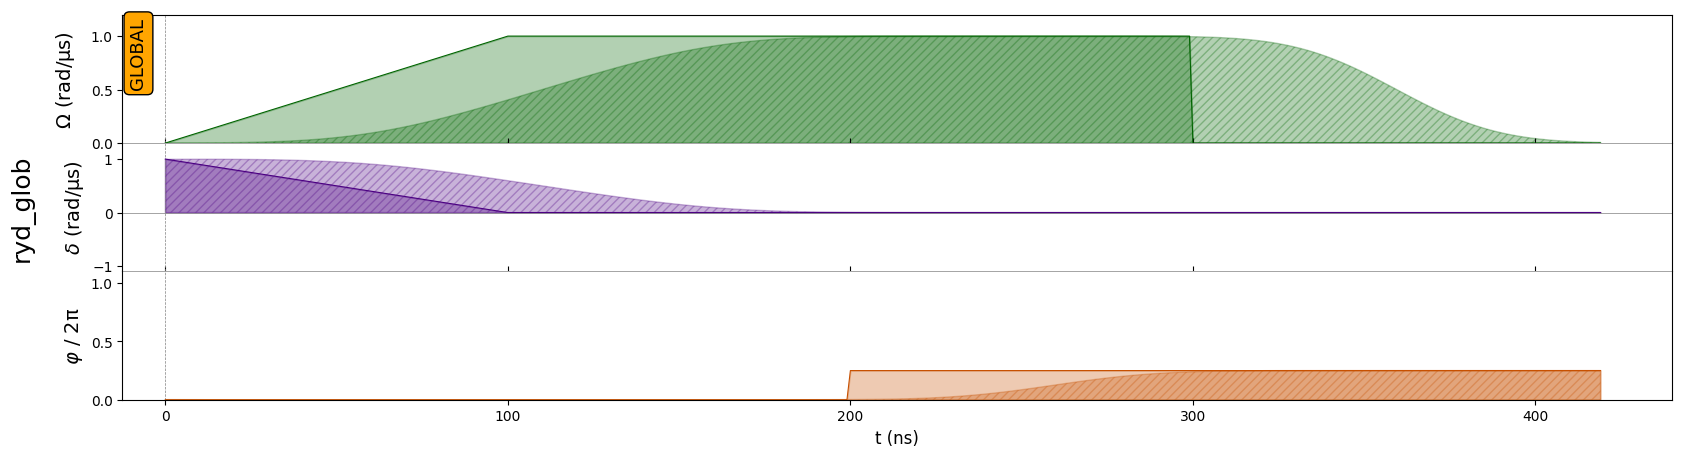

drive:
1 * ((get_item([0.005283597385522133, 0.004765372898433619, 0.004315107658668559, 0.003927990388763221, 0.003599698316870675, 0.0033263839303552026, 0.0031046610543745672, 0.0029315904698656225, 0.0028046652599005824, 0.0027217960476871132, 0.0026812962639532994, 0.0026818675564044357, 0.002722585429680434, 0.002802885181054615, 0.002922548175226012, 0.0030816884811684987, 0.003280739875286923, 0.0035204431982144516, 0.00380183403758746, 0.004126230696111442, 0.0044952223932549365, 0.004910657639974894, 0.005374632719016791, 0.005889480198495974, 0.006457757403636153, 0.007082234770633989, 0.007765884007587484, 0.008511865990139306, 0.00932351832387397, 0.010204342511429284, 0.011157990669600945, 0.012188251750302184, 0.013299037228936127, 0.014494366234355282, 0.01577835010598847, 0.017155176375705055, 0.01862909218438374, 0.020204387155773065, 0.021885375762895825, 0.023676379234743933, 0.025581707063186573, 0.027605638181652722, 0.029752401898107062, 0.032026158674917565, 0.0

In [89]:
# Samples of the Sequence are in full line, modulated samples in hatched
# mod_schedule_from_seq contains the modulated samples of the analog_seq
seq.draw(draw_phase_curve=True)
mod_schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(seq, modulation=True)
print(mod_schedule_from_seq)

## What should be favoured ?

To execute jobs on Pasqal QPUs, you should favour converting a Pulser Sequence into a MyQLM Job instead of defining an equivalent MyQLM Schedule step-by-step. This is mostly because Pulser is closer to the Pasqal hardware, hence defining your own Ising Hamiltonian to be implemented on Pulser is not easy:

- Hardware specificities (like maximum amplitude and maximum duration of a pulse) are checked when adding a Pulse to a Sequence, which is not the case when you define your own Hamiltonian.
- Making operations on Hamiltonians can lead to a modification of the register you want to implement, and all registers can't be implemented on Pasqal QPUs.
- Pulser adds delays between pulses for them to be the closest to the desired behaviour. It takes care of the modulation bandwidth of the hardware components. For instance, the `Sequence` presented above would by default not be implemented with the protocol "no-delay" (default protocol is "min-delay"). See the example below.
- The Sequence/Ising Hamiltonian you define is a set of instructions for the hardware. Only Pulser implements a model of how the hardware behaves (see previous subsection).
- There are some hardware subtleties that can improve the implementation of your Ising Hamiltonian on Pasqal hardware, [like EOM mode](https://pulser.readthedocs.io/en/stable/tutorials/output_mod_eom.html), that cannot be made explicit in an Ising Hamiltonian.

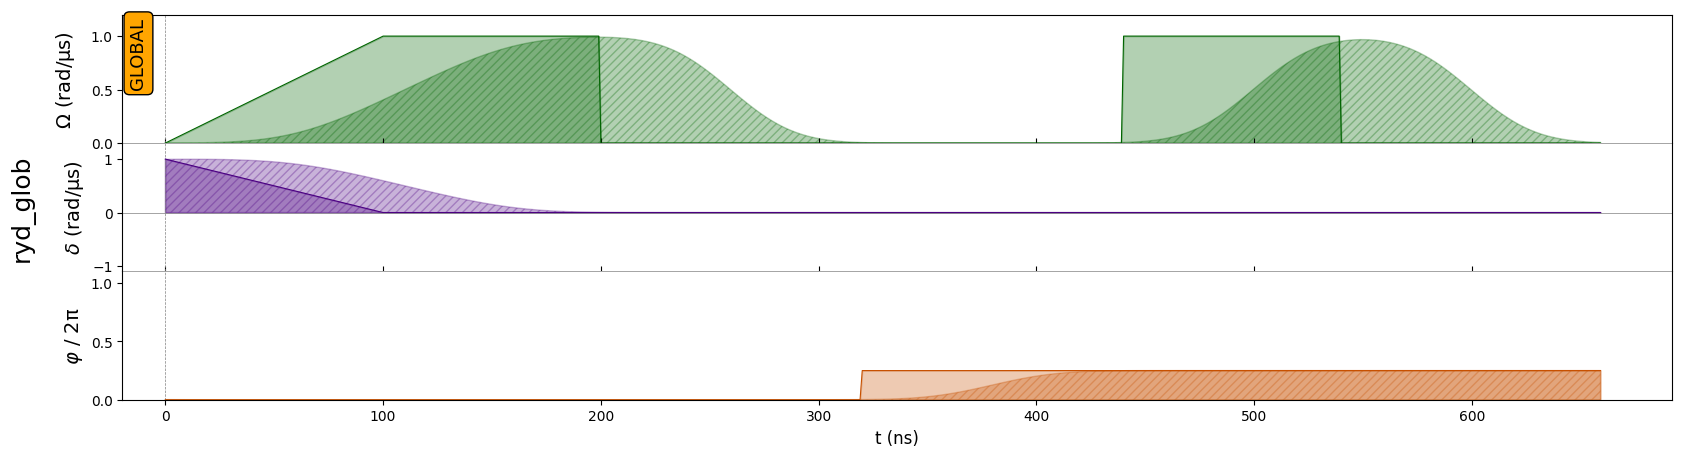

In [90]:
pulser_seq = Sequence(register, AnalogDevice)
pulser_seq.declare_channel("ryd_glob", "rydberg_global")
pulser_seq.add(
    Pulse(
        CustomWaveform([omega_t(t=ti / 1000) for ti in range(int(t0 * 1000))]),
        CustomWaveform(
            [delta_t(t=ti / 1000, u=0) for ti in range(int(t0 * 1000))]
        ),  # no parametrized sequence for the moment
        0,
    ),
    "ryd_glob",
)  # corresponds to H0
pulser_seq.add(
    Pulse.ConstantPulse(int(t1 * 1000), 1, 0, 0), "ryd_glob"
)  # corresponds to H1
pulser_seq.add(
    Pulse.ConstantPulse(int(t2 * 1000), 1, 0, np.pi / 2), "ryd_glob"
)  # corresponds to H2
pulser_seq.draw(draw_phase_curve=True)

In [91]:
schedule_from_pulser_seq = IsingAQPU.convert_sequence_to_schedule(pulser_seq)
print(schedule_from_pulser_seq)
print("- Obtained schedule is the same as the concatenation of H0, H1 and H2 ?")
print(f"- That's {are_equivalent_schedules(schedule_from_pulser_seq, schedule(u=0))}")

drive:
1 * ((get_item([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.10999999999999999, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21000000000000002, 0.21999999999999997, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29000000000000004, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42000000000000004, 0.42999999999999994, 0.43999999999999995, 0.44999999999999996, 0.45999999999999996, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.5800000000000001, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.8500000000000001, 0.8599999999999999, 0.8699999999999999, 0.8799999999999999, 0.8899999999999999, 0.8999999999999999, 0.9099999999999999, 0.9199999999999999, 0.9299999999999999, 0.94, 0.95, 0.96,